<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Language_modeling/LSTM_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM language modeling

## Imports

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import re
import string


from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [1]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load dataset

In [5]:
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

## Preprocessing and creating vocab

> Preprocess

> Get vocab or `set` of strings:

  1. split train samples into separate sentences using `sent_tokenize` from `nltk`. Each separate sentence would be a single instance of training samples.

  2. Drop sentences with words num **above** `word_threshold`

  3. Count each word in resulting sentences (Document Frequency). (use `word_tokenize` to split into separate words)

  4. Create `vocab` object of `set`, put `<unk>, <bos>, <eos>, <pad>` and `vocab_size` of the most frequent words.

Get separate sentences and put them in list

In [146]:
sentences = []
word_threshold = 32

for sentence in dataset['train']['text']:
    sentences.extend([x.lower() for x in sent_tokenize(sentence) if len(x.split()) < word_threshold])

words = Counter()
for sentence in sentences:
    words.update(word_tokenize(sentence))

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

most_common_words = words.most_common(vocab_size)
vocab.update([word for word, _ in most_common_words])

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [151]:
print(f"Sentences total:{len(sentences)}\nVocab len: {len(vocab)}")

Sentences total:219930
Vocab len: 40004


Add vocab_size of the most frequent words into vocab

Bathe in tests

In [152]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab

assert len(vocab) == vocab_size + 4

In [153]:
print("Total words in vocab:", len(vocab))

Total words in vocab: 40004


### Prepare dataset

Create `__getitem__` (return data sample by input idx) in `WordDataset`.

add service tokens for the beginning and the end of sequence and tokenize the sentence using `word_tokenize` and match it with indices from `word2idx`

In [156]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(char, self.unk_id) for char in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:

    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)
    new_batch = []
    for seq in input_batch:
        for _ in range(max_seq_len - len(seq)):
            seq.append(pad_id)
        new_batch.append(seq)

    sequences = torch.LongTensor(new_batch).to(device)
    new_batch = {'input_ids': sequences[:,:-1], 'target_ids': sequences[:,1:]}
    return new_batch

In [165]:
batch_size = 32

train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5) #data leak

train_loader = DataLoader(WordDataset(train_sentences), collate_fn=collate_fn_with_padding, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(WordDataset(eval_sentences), collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_loader = DataLoader(WordDataset(test_sentences), collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [166]:
first_batch = next(iter(val_loader))
input_ids = first_batch['input_ids']
first_tensor = input_ids[0]
first_word = [ind2word[x.item()] for x in first_tensor]
print("First value in letters:", first_word)

First value in letters: ['<bos>', 'i', 'admit', 'that', 'maybe', 'the', '<unk>', 'of', 'the', 'bugs', 'were', 'a', 'little', 'more', 'static', 'than', 'in', '<unk>', 'and', 'they', 'only', 'had', 'four', 'legs', '<unk>', '<unk>', '<unk>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']


## Model architecture and training

In [18]:
class CFG:
  epochs = 6

#### Baseline

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, vocab_dim, rnn_layers=2, bi=True):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_dim)
        self.rnn = nn.LSTM(input_size=vocab_dim, hidden_size=vocab_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
        self.fc_1 = nn.Linear(vocab_dim*(bi+1), vocab_dim)
        self.fc_2 = nn.Linear(vocab_dim, vocab_size)

    def forward(self, x):
        embedding = self.embedding(x)
        x, _ = self.rnn(embedding)
        x = torch.tanh(x)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

### Evaluation func (1 point)

perplexity is an exponent applied to cross-entropy loss

In [48]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Processing Test data:'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

#### Plot hist

In [21]:
def plot_loss_and_perp(hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val):
    epochs = range(1, len(hist_loss_train) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist_loss_train, label='Training Loss')
    plt.plot(epochs, hist_loss_val, label='Validation Loss', color='red')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist_perp_train, label='Training Perplexity')
    plt.plot(epochs, hist_perp_val, label='Validation Perplexity', color='red')
    plt.title('Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Train func (1 point)

In [51]:
def get_epoch(model, optimizer, criterion, epoch, loader, name='Train', scheduler=False):
  if name=='Train':
    model.train()
  else:
    model.eval()
  avg_loss = 0
  avg_perplexity = 0
  for batch in tqdm(loader, desc=f'{name} Epoch: {epoch+1}'):
    xs, ys = batch['input_ids'].to(device), batch['target_ids'].to(device)
    logits = model(xs)
    loss = criterion(logits.flatten(start_dim=0, end_dim=1), ys.flatten())
    if name=='Train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_perplexity += torch.exp(loss).item()
    if scheduler:
     scheduler.step()
  return avg_loss / len(loader), avg_perplexity / len(loader)


def fit(model, optimizer, criterion, train_loader, eval_loader, scheduler):
  best_perp = np.inf
  best_model = None
  hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val = [], [], [], []
  for epoch in tqdm(range(CFG.epochs)):
    train_loss, train_perp = get_epoch(model, optimizer, criterion, epoch, train_loader, scheduler=scheduler)
    hist_loss_train.append(train_loss)
    hist_perp_train.append(train_perp)

    val_loss, val_perp = get_epoch(model, optimizer, criterion, epoch, eval_loader, name='Val', scheduler=scheduler)
    hist_loss_val.append(val_loss)
    hist_perp_val.append(val_perp)


    t_loss = round(hist_loss_train[-1], 5)
    v_loss = round(hist_loss_val[-1], 5)
    t_perplexity = round(hist_perp_train[-1], 5)
    v_perplexity = round(hist_perp_val[-1], 5)
    if v_perplexity < best_perp:
      best_model = model.state_dict()

    #print('Evaluation perplexity:',evaluate(model, criterion, eval_loader))
    print(f"Epoch: {epoch+1}.\n\tTrain loss: {t_loss}\n\ttest_loss: {v_loss}"
          f"\n\ttrain_perplexity: {t_perplexity}\n\ttest_perplexity: {v_perplexity}")

  plot_loss_and_perp(hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val)
  model.load_state_dict(best_model)
  model.eval()
  return model, (hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val)

### Func for models

In [186]:
def train_func(model_class, vocab, train_loader, eval_loader, pad=word2ind["<pad>"], dim_size=256, lr=3e-4):
  model = model_class(len(vocab), dim_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss(ignore_index=pad)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.1)
  best_model, history = fit(model, optimizer, criterion, train_loader, eval_loader, scheduler)
  return best_model, criterion, history

In [ ]:
def top_k_logits(logits, k):
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_value = values[-1]  # Get the last value to use as the threshold for top k
    return torch.where(logits < min_value, torch.full_like(logits, float('-inf')), logits)


def generate_text(model, start_sequence, length, temperature=1.0, k=10, i2w=ind2word, w2i=word2ind):
    model.eval()
    words = start_sequence.split()
    special_tokens_idx = [w2i[token] for token in ['<eos>', '<bos>', '<pad>', '<unk>']]

    for _ in range(length):
        input_seq = [w2i.get(word, w2i['<unk>']) for word in words[-(word_threshold-1):]]
        input_tensor = torch.tensor([input_seq]).to(device)

        with torch.no_grad():
            logits = model(input_tensor)[0, -1]
            # Exclude special tokens by setting their probabilities to -inf
            for token_idx in special_tokens_idx:
                logits[token_idx] = float('-inf')
            # Apply top-k
            logits = top_k_logits(logits, k)
            probabilities = F.softmax(logits / temperature, dim=0)
            predicted_index = torch.multinomial(probabilities, 1).item()
            predicted_word = i2w[predicted_index]
        if predicted_word != words[-1]:
            words.append(predicted_word)
        elif predicted_word == '<eos>':
            # If it is, stop generating text
            break


    return ' '.join(words)

### Experiment 1

> batchsize 32

> standard data preprocessing from the seminar

  0%|          | 0/3 [00:00<?, ?it/s]

Train Epoch: 1:   0%|          | 0/6186 [00:00<?, ?it/s]

Val Epoch: 1:   0%|          | 0/3437 [00:00<?, ?it/s]

Epoch: 1.
	Train loss: 2.37071
	test_loss: 1.41651
	train_perplexity: 132.29902
	test_perplexity: 4.17852


Train Epoch: 2:   0%|          | 0/6186 [00:00<?, ?it/s]

Val Epoch: 2:   0%|          | 0/3437 [00:00<?, ?it/s]

Epoch: 2.
	Train loss: 1.0019
	test_loss: 0.63922
	train_perplexity: 2.81388
	test_perplexity: 1.90532


Train Epoch: 3:   0%|          | 0/6186 [00:00<?, ?it/s]

Val Epoch: 3:   0%|          | 0/3437 [00:00<?, ?it/s]

Epoch: 3.
	Train loss: 0.4186
	test_loss: 0.25233
	train_perplexity: 1.53373
	test_perplexity: 1.28922


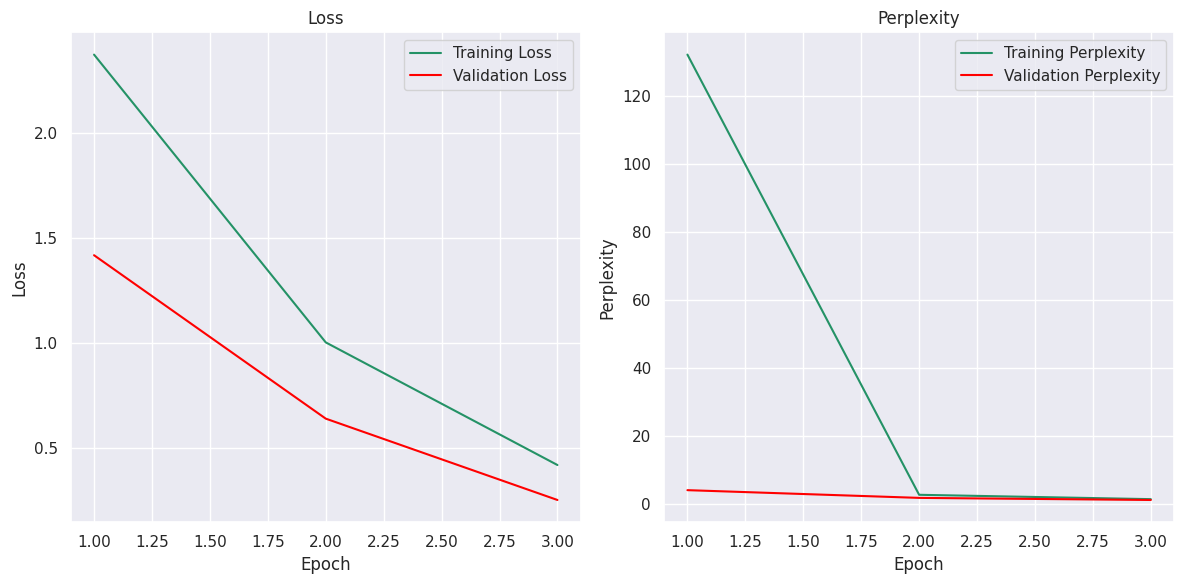

In [111]:
best_model, criterion, history = train_func(LSTMModel, vocab, train_loader, val_loader)

In [112]:
evaluate(best_model, criterion, test_loader)

1.564580672557943

So the LSTM baseline perplexity is 1.25 (there is a daat leak after all in seminar) however text doesn't generate anything comprehensible. Moreover due to too much <eos> it lookls like the generate function return every word with a period. (likely due to the vast amount of unfiltered words with periods after them, so further filtering is required).

Without data leak perplexity is a bit higher. 2.1
    

In [118]:
generate_text(best_model, "I like this movie", 10)

'I like this movie perfectly. pinned entertainment. picture. picture. version. picture. area. picture. what.'

### Experiment 2

Lets consider a different way to preprocess data

In [7]:
word_threshold = 42
stop_words = set(stopwords.words("english")) # bad idea

In [185]:
def build_vocab_and_count_sentences(dataset, word_threshold=32, min_word_freq=5):
    words = Counter()
    sentences = []

    all_text = dataset['train']['text'] + dataset['test']['text']

    # First pass: Tokenize and count word frequencies across all sentences
    for article in tqdm(all_text, desc='Counting word frequencies'):
        for sentence in sent_tokenize(article.lower()):
            cleaned_sentence = re.sub(r'<br\s*/?>|[\.\,]', ' ', sentence)  # Simplified cleaning
            cleaned_sentence = re.sub(r'[^\w\s]', '', cleaned_sentence)  # Remove non-word chars
            tokens = word_tokenize(cleaned_sentence)
            words.update(token for token in tokens if token not in {'<unk>', '<bos>', '<eos>', '<pad>'})

    # Build vocab with only words that meet the frequency threshold
    vocab = {word for word, freq in words.items() if freq >= min_word_freq}
    vocab.update({'<unk>', '<bos>', '<eos>', '<pad>'})

    # Second pass: Tokenize sentences and replace words not in vocab with '<unk>'
    for article in tqdm(all_text, desc='Tokenizing sentences'):
        for sentence in sent_tokenize(article.lower()):
            cleaned_sentence = re.sub(r'<br\s*/?>|[\.\,]', ' ', sentence)
            cleaned_sentence = re.sub(r'[^\w\s]', '', cleaned_sentence)
            tokens = [token if token in vocab else '<unk>' for token in word_tokenize(cleaned_sentence)]
            if 0 < len(tokens) <= word_threshold:
                sentences.append(tokens)

    return vocab, sentences

custom_vocab, custom_sentences = build_vocab_and_count_sentences(dataset)


Processing train data:   0%|          | 0/25000 [00:00<?, ?it/s]

Processing test data:   0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print(dataset['train']['text'][0].split('.')[9])
print(custom_sentences[0])

custom_word2ind = {char: i for i, char in enumerate(custom_vocab)}
custom_ind2word = {i: char for char, i in custom_word2ind.items()}

In [188]:
class CustomWordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = custom_word2ind['<unk>']
        self.bos_id = custom_word2ind['<bos>']
        self.eos_id = custom_word2ind['<eos>']
        self.pad_id = custom_word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [custom_word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)


def custom_collate_fn_with_padding(input_batch: List[List[int]], pad_id=custom_word2ind['<pad>']) -> torch.Tensor:

    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for seq in input_batch:
        for _ in range(max_seq_len - len(seq)):
            seq.append(pad_id)
        new_batch.append(seq)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {'input_ids': sequences[:,:-1], 'target_ids': sequences[:,1:]}
    return new_batch

In [189]:
batch_size = 128

custom_train_sentences, custom_eval_sentences = train_test_split(custom_sentences, test_size=0.2)
custom_eval_sentences, custom_test_sentences = train_test_split(custom_eval_sentences, test_size=0.5)

custom_train_loader = DataLoader(CustomWordDataset(custom_train_sentences), collate_fn=custom_collate_fn_with_padding, batch_size=batch_size, shuffle=True)
custom_val_loader = DataLoader(CustomWordDataset(custom_eval_sentences), collate_fn=custom_collate_fn_with_padding, batch_size=batch_size)
custom_test_loader = DataLoader(CustomWordDataset(custom_test_sentences), collate_fn=custom_collate_fn_with_padding, batch_size=batch_size)

In [ ]:
first_batch = next(iter(custom_val_loader))
input_ids = first_batch['input_ids']
first_tensor = input_ids[0]
first_words = [custom_ind2word[x.item()] for x in first_tensor]
print("values:", first_word)

In [ ]:
CFG.epochs = 3
custom_best_model, custom_criterion, custom_history = train_func(LSTMModel,
                                                                 custom_vocab,
                                                                 custom_train_loader,
                                                                 custom_val_loader,
                                                                 pad=custom_word2ind['<pad>'])

print(evaluate(custom_best_model, custom_criterion, custom_test_loader))

print(generate_text(custom_best_model, "I like this movie", 10,
                    i2w=custom_ind2word, w2i=custom_word2ind))

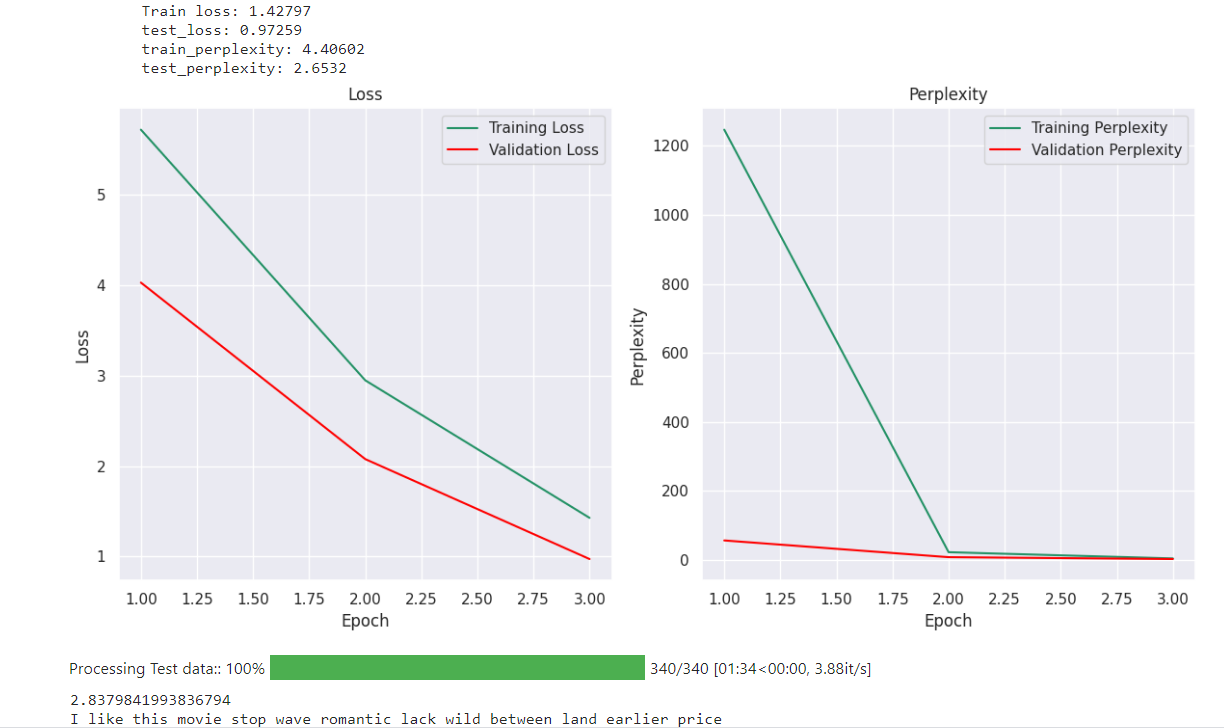

We've eliminated SOME problems however the generated text is still a piece of shyte - we don't have periods after each word anymore but that doesnt help - it's still incomprehensible

3 epochs. perplexity 2.1 dataleak

2.8 with no dataleak which is still pretty sus

### Experiment 3:

### Experiment 3:  Slow Ugly Monster

In [ ]:
class FrankensteinModel(nn.Module):
    def __init__(self, vocab_size, vocab_dim, rnn_layers=4, bi=True, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_dim)
        self.rnn = nn.LSTM(input_size=vocab_dim, hidden_size=vocab_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
        self.gru = nn.GRU(input_size=vocab_dim*(bi+1), hidden_size=vocab_dim, num_layers=2, batch_first=True, bidirectional=bi)
        self.layernorm = nn.LayerNorm(vocab_dim * (bi+1))
        self.fc_1 = nn.Linear(vocab_dim*(bi+1), vocab_dim)
        self.dropout =  nn.Dropout(dropout)
        self.fc_2 = nn.Linear(vocab_dim, vocab_size)

    def forward(self, x):
        embedding = self.embedding(x)
        x, _ = self.rnn(embedding)
        # no activation, lstm and gru got it after all
        x, _ = self.gru(x)
        x = self.layernorm(x)
        x = torch.tanh(x)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

In [ ]:
CFG.epochs = 3
custom_best_model, custom_criterion, custom_history = train_func(FrankensteinModel,
                                                                 custom_vocab,
                                                                 custom_train_loader,
                                                                 custom_val_loader,
                                                                 pad=custom_word2ind['<pad>'])

print(evaluate(custom_best_model, custom_criterion, custom_test_loader))

print(generate_text(custom_best_model, "I like this movie", 10,
                    i2w=custom_ind2word, w2i=custom_word2ind))

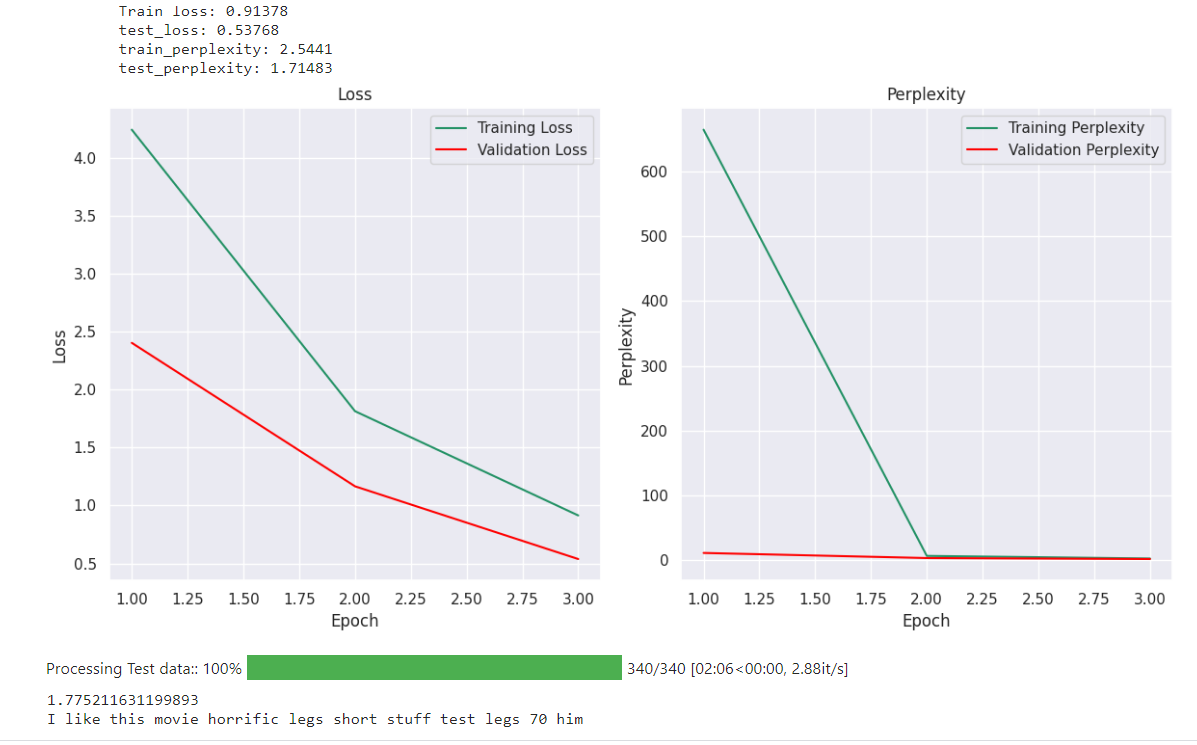

It worked better than I've expected however with that amount of layers (this time its 2,1,+2fc but there could be 4, 4 3fc, etc) even layernorm and dropout won't help

### Experiment 4: Beam search in text generation

In [ ]:
def beam_search(model, start_sequence, length, beam_width=5, temperature=1.0, k=10, i2w=ind2word, w2i=word2ind):
    model.eval()
    beams = [([w2i['<bos>']], 0)] if '<bos>' in w2i else [([], 0)]
    special_tokens_idx = [w2i[token] for token in ['<eos>', '<bos>', '<pad>', '<unk>']]

    for _ in range(length):
        new_beams = []
        for beam in beams:
            input_seq = [w2i.get(word, w2i['<unk>']) for word in beam[0]]
            input_tensor = torch.tensor([input_seq]).to(device)

            with torch.no_grad():
                logits = model(input_tensor)[0, -1]
                logits[special_tokens_idx] = float('-inf')  # Exclude special tokens
                logits = top_k_logits(logits, k)
                probabilities = F.softmax(logits / temperature, dim=0)
                topk_probs, topk_indices = torch.topk(probabilities, beam_width)

                for i in range(beam_width):
                    predicted_index = topk_indices[i].item()
                    predicted_word = i2w[predicted_index]
                    if predicted_word == '<eos>':  # Stop extending this beam on <eos>
                        new_beams.append((beam[0] + [predicted_word], beam[1]))
                        continue
                    new_seq = beam[0] + [predicted_index]
                    new_log_prob = beam[1] + topk_probs[i].log().item()  # Logprob for num stability
                    new_beams.append((new_seq, new_log_prob))

        # Keep top beam_width beams
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        # Stop if all top beams end with <eos>
        if all(seq[-1] == w2i['<eos>'] for seq, _ in beams):
            break

    best_sequence = beams[0][0]
    return ' '.join([i2w[idx] for idx in best_sequence if idx not in special_tokens_idx])  # Exclude special tokens

In [ ]:
print(beam_search(custom_best_model, "I like this movie", 8, beam_width=5, temperature=0.7, k=8, i2w=custom_ind2word, w2i=custom_word2ind))

Results as ```'I like this movie legs legs legs perspective higher social horrific horrific'``` I consider as a failure

Try another version of beam search

In [ ]:
def top_k(logits, k):
    if k == 0:
        return logits
    # Ensure logits is at least 2D
    was_1d = False
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
        was_1d = True

    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]  # Now this is safe, logits is at least 2D

    # Apply filtering: Set logits below the k-th to -inf
    filtered_logits = torch.where(logits < min_values.unsqueeze(-1), torch.ones_like(logits) * float('-inf'), logits)

    if was_1d:
        # If logits was originally 1D, make sure to squeeze back the extra dimension we added
        filtered_logits = filtered_logits.squeeze(0)

    return filtered_logits


def beam_search(model, start_sequence, length, beam_width=5, temperature=1.0, k=10, i2w=custom_ind2word, w2i=custom_word2ind):
    model.eval()
    beams = [([w2i['<bos>']], 0)] if '<bos>' in w2i else [([], 0)]
    special_tokens_idx = [w2i[token] for token in ['<eos>', '<bos>', '<pad>', '<unk>']]

    for _ in range(length):
        new_beams = []
        for beam in beams:
            input_seq = [w2i.get(word, w2i['<unk>']) for word in beam[0]]
            input_tensor = torch.tensor([input_seq]).to(device)

            with torch.no_grad():
                logits = model(input_tensor)[0, -1]
                logits[special_tokens_idx] = float('-inf')  # Exclude special tokens
                logits = top_k_logits(logits, k)
                probabilities = F.softmax(logits / temperature, dim=0)
                topk_probs, topk_indices = torch.topk(probabilities, beam_width)

                for i in range(beam_width):
                    predicted_index = topk_indices[i].item()
                    predicted_word = i2w[predicted_index]

                    # Check if the predicted word is the same as the last word in the current beam sequence
                    if beam[0] and predicted_word == i2w[beam[0][-1]]:
                        continue  # Skip this word to avoid immediate repetition

                    if predicted_word == '<eos>':  # Stop extending this beam on <eos>
                        new_beams.append((beam[0] + [predicted_index], beam[1]))
                    else:
                        new_seq = beam[0] + [predicted_index]
                        new_log_prob = beam[1] + topk_probs[i].log().item()
                        new_beams.append((new_seq, new_log_prob))

        # Keep top beam_width beams
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        # Stop if all top beams end with <eos>
        if all(seq[-1] == w2i['<eos>'] for seq, _ in beams):
            break

    best_sequence = beams[0][0]
    final_sequence = ' '.join([i2w[idx] for idx in best_sequence if idx not in special_tokens_idx])  # Exclude special tokens
    return start_sequence+' ' + final_sequence


In [ ]:
sent = 'Beyond the horizon of the places'
print(generate_text(custom_best_model, sent, 9))
print(beam_search(custom_best_model, sent, 9, beam_width=5, temperature=1, k=8, i2w=custom_ind2word, w2i=custom_word2ind))

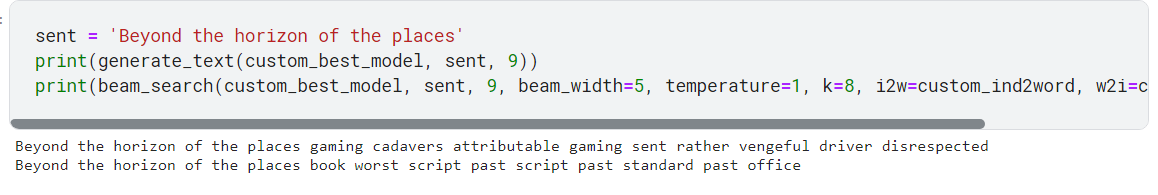

Shyte

### Experiment 5: UNK instead of PAD

since crossentropyloss allows to ignore only single index (wryyyy?!), lets try to ignore unk instead of pad

In [ ]:
CFG.epochs = 3
custom_best_model, custom_criterion, custom_history = train_func(LSTMModel,
                                                                 custom_vocab,
                                                                 custom_train_loader,
                                                                 custom_val_loader,
                                                                 pad=custom_word2ind['<unk>'])

print(evaluate(custom_best_model, custom_criterion, custom_test_loader))

print(generate_text(custom_best_model, "I like this movie", 10,
                    i2w=custom_ind2word, w2i=custom_word2ind))

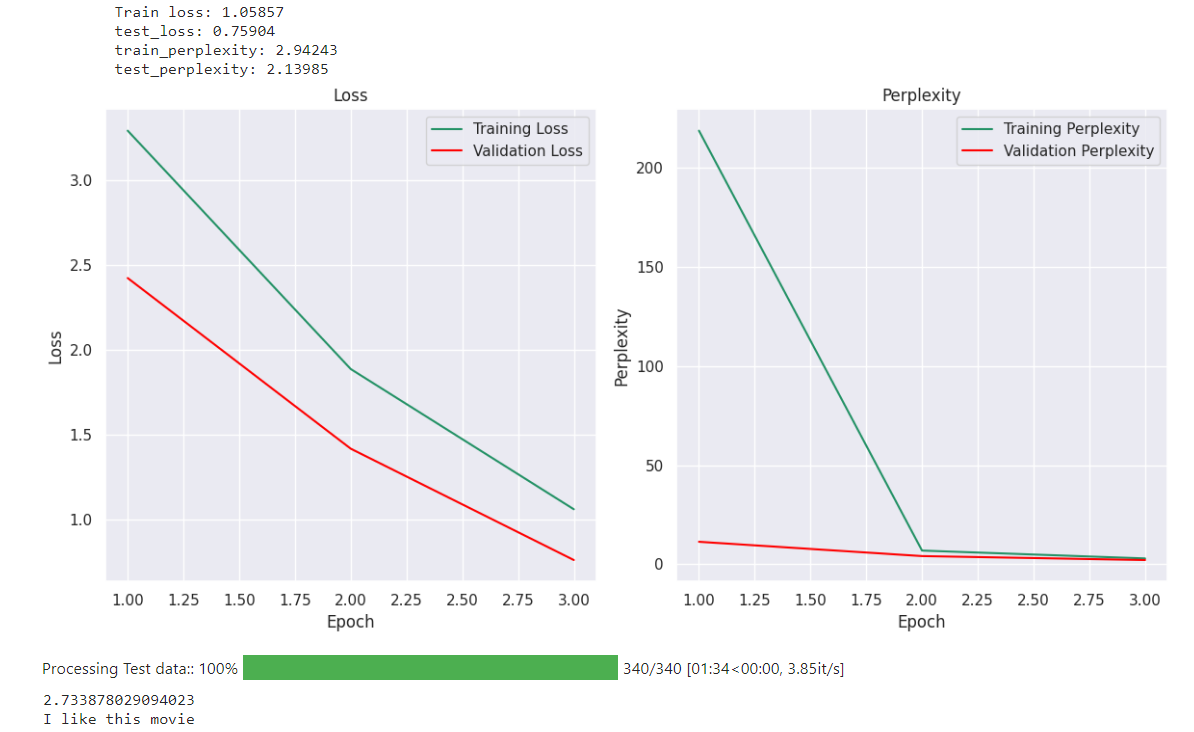

In [ ]:
for n in range(5, 9):
    print(generate_text(custom_best_model, "This is the ", n,
                        i2w=custom_ind2word, w2i=custom_word2ind))

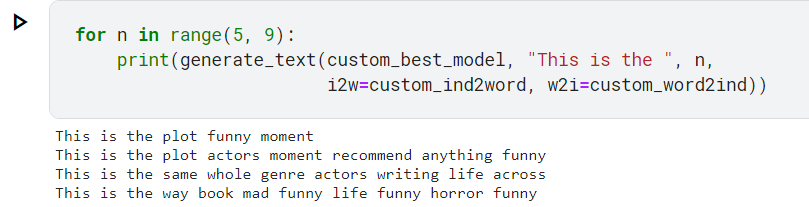

Interesting result. but more work should be done to ignore both pad and unk indices

## Report

Well first of all lets address the elephant in the room - why train loss is higher than test on graph. well, thats because the train is computed per batch while hmm training and first batches on epoch produce higher error and afterwards the avg is taken. On the other hand test\val are computed after the training epoch and provide the best (likely less than las train result) results.

graphs are pasted as images due to colab being colab so I had to revert to Kaggle notebook. All praise Kaggle, eventhough its not convenient to save outputs.

Another thing is as it has already been mentioned above - dataleak in seminar-given code. eval and test DataLoaders get data from the same dataset as the training set thus providing a dataleak by allowing to peek into test results (however the generated result sucks regardless). Good thing I've noticed it before handing down the notebook.

Also it is worth mentioning that ```dataset['test']``` was just dangling unused, so the decision was to make use of it and concatenate with train set, we weren't using it anyways

Overall basic LSTM implementation suffers from the same issue as more advanced with a better data preparation - generated data makes no sence.

If I had time it would be interesting to use more advanced techniques like beam search. However I have implemented top k logits even though I am not satisfied.

I'd assume removing both UNK and PAD would help more as well as modifying top-k function and adding more recurrent layers

In [2]:
import pandas as pd

model_names = ['LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM+GRU', 'LSTM']
custom_preprocess = [False, False, True, True, True, True]
data_leak = [True, False, True, False, False, False]
ignore_index = ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<unk>']
perplexity_values = [1.25, 2.1, 2.1, 2.6, 1.7, 2.7]
experiment = [1,1,2,2,3,5]
experiment_index = range(1, len(model_names) + 1)


data = {'Index': experiment_index,
        'Experiment': experiment,
    'Model Name': model_names,
    'Custom Preprocess': custom_preprocess,
    'Data Leak': data_leak,
    'Ignore index': ignore_index,
    'Perplexity': perplexity_values}

df = pd.DataFrame(data)
df.set_index('Index', inplace=True)
df

,Experiment,Model Name,Custom Preprocess,Data Leak,Ignore index,Perplexity
Index,,,,,,
1,1,LSTM,False,True,<pad>,1.25
2,1,LSTM,False,False,<pad>,2.10
3,2,LSTM,True,True,<pad>,2.10
4,2,LSTM,True,False,<pad>,2.60
5,3,LSTM+GRU,True,False,<pad>,1.70
6,5,LSTM,True,False,<unk>,2.70
